In [1]:
import os, sys, time, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import cma
from PIL import Image


from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr

from gvxrPython3.utils import visualise # Visualise the 3D environment if k3D is supported
from gvxrPython3.utils import plotScreenshot # Visualise the 3D environment using Matplotlib

# from gvxrPython3.utils import loadSpekpySpectrum # Generate and load an X-ray spectrum using Spekpy
from gvxrPython3.utils import loadXpecgenSpectrum # Generate and load an X-ray spectrum using xpecgen

spekpy is not install, you won't be able to load a beam spectrum using spekpy
SimpleGVXR 2.0.6 (2023-05-23T20:42:48) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 2.0.6 (2023-05-23T20:43:44) [Compiler: Microsoft Visual Studio] on Windows


In [2]:
current_folder = str(globals()['_dh'][0])
print(current_folder)

C:\Users\user\dr frank papers'\simulations\new


In [3]:
def average_images(image_paths):
    """Average a list of images."""
    # Load the first image to get the shape
    sample_image = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
    if sample_image is None:
        raise ValueError(f"Failed to load image: {image_paths[0]}")
    
    avg_image = np.zeros_like(sample_image, dtype=float)
    
    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Failed to load image: {path}")
        avg_image += image.astype(float)
    
    avg_image /= len(image_paths)
    
    return cv2.medianBlur(avg_image.astype(np.single), 3)

In [4]:
def flatField(img, white, dark):
#     epsilon = 1e-6
    epsilon = 0.0
    return (img) / (white)    
    return (img - dark + epsilon) / (white - dark + epsilon)

In [5]:
#path for my recently acquired images stored in PhD file
dark_field_paths = [f'C:/Users/user/phd/Dataoff/darkfd/darkfd_{i}.tiff' for i in range(10)]
white_field_paths = [f'C:/Users/user/phd/Dataoff/whitefd/whitefd_{i}.tiff' for i in range(10)]
raw_image_paths = [f'C:/Users/user/phd/Dataoff/rawimages/tiffile/raw_images_{i}.tiff' for i in range(103)]



# def convert_to_grayscale_uint8(image_path):
#     # Open the image
#     img = Image.open(image_path)
    
#     # Convert to grayscale
#     img_gray = img.convert('L')
    
#     # Convert to uint8
#     img_array = np.array(img_gray)
#     img_uint8 = Image.fromarray(img_array.astype('uint8'))
    
#     # Save the converted image (you can modify the save path if needed)
#     img_uint8.save(image_path)
#     print(f"Converted {image_path} to grayscale uint8.")

# # Paths
# dark_field_paths = [f'C:/Users/user/phd/Dataoff/darkfd/darkfd_{i}.tiff' for i in range(10)]
# white_field_paths = [f'C:/Users/user/phd/Dataoff/whitefd/whitefd_{i}.tiff' for i in range(10)]
# raw_image_paths = [f'C:/Users/user/phd/Dataoff/rawimages/tiffile/raw_images_{i}.tiff' for i in range(103)]

# # Convert all images
# for path in dark_field_paths + white_field_paths + raw_image_paths:
#     convert_to_grayscale_uint8(path)


In [6]:
#Average the dark field and white field images
I_dark = average_images(dark_field_paths)
I_white = average_images(white_field_paths)
I_raw = average_images(raw_image_paths)

test = I_white == 0
I_white[test] += 1
I_raw[test] += 1

I_flat = flatField(I_raw, I_white, I_dark)


In [7]:
sod = 43
sdd = 59

In [8]:
Ti90Al10 = 5.68
x_src = 0
y_src = 0
z_src = sod

x_det = 0
y_det = 0
z_det = -(sdd - sod)

x_obj = 0
y_obj = 0
z_obj = 0

alpha_x = 0 
alpha_y = 0
alpha_z = 0

x_rot = 0
y_rot = 0
z_rot = 0

x_default = [
    x_src,
    y_src,
    z_src,

    x_det,
    y_det,
    z_det,

    x_obj,
    y_obj,
    z_obj,

#     alpha_x, 
#     alpha_y,
#     alpha_z,

#     x_rot,
#     y_rot,
#     z_rot,
]


In [9]:
# Initialise gVXR using our JSON file
json2gvxr.initGVXR("simulation1.json", "OPENGL", 3, 2)

Create an OpenGL context: 512x512


In [10]:
# Load our source properties
json2gvxr.initSourceGeometry("sim2.json")
json2gvxr.initSpectrum(verbose=0)

gvxr.setSourcePosition(x_src, y_src, z_src, "mm")

Set up the beam
	Source position: [0.0, 0.0, 0.0, 'mm']
	Source shape: PointSource


In [11]:
def getAverageEnergy(k, f):
    
    avg = 0
    for energy, count in zip(k, f):
        avg += energy * count
        
    return avg / np.sum(f)

In [12]:
# Load our detector
json2gvxr.initDetector("simulation1.json")
    # "NumberOfPixels": [2880, 2880],

gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

Set up the detector
	Detector position: [0.0, 0.0, 0.0, 'mm']
	Detector up vector: [0, -1, 0]
	Number of pixels: [640, 480]
	Detector number of pixels: [640, 480]
	Pixel spacing: [0.23, 0.23, 'mm']


In [13]:
# Load our samples
json2gvxr.initSamples("sim2.json", verbose=0)

gvxr.setDensity("cuboid2", Ti90Al10, "g/cm3")

In [14]:
ID = "cuboid2"
gvxr.rotateNode(ID, 90, 1.0, 0.0, 0.0)
gvxr.moveToCentre()
gvxr. applyCurrentLocalTransformation(ID)

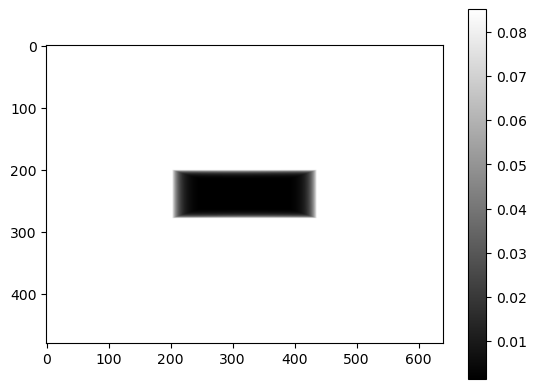

In [15]:
# Let's get an x-ray image
fig = plt.figure()
plt.imshow(gvxr.computeXRayImage(), cmap="gray")
plt.colorbar()
plt.show()

In [16]:
visualise()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [17]:
import cma
from tifffile import imread, imwrite

In [18]:
# total_nb_projs = 544
# angular_span = 360
# angular_step = 360 / 544

# fnames_images = []
# angles = []

# for i in range(total_nb_projs):
#     angles.append(i*angular_step)
#     fnames_images.append(current_folder + "/Dataoff/rawimages/raw_images_" + "{:02d}".format(i) + ".tif") 

total_nb_projs = 200
angular_span = 360
angular_step = 360 / total_nb_projs

fnames_images = []
angles = []

for i in range(total_nb_projs):
    angles.append(i * angular_step)
    #fnames_images.append(current_folder + "/Dataoff/rawimages/tiffile/raw_images_" + str(i) + ".tiff")
    fnames_images.append("C:/Users/user/phd/Dataoff/rawimages/tiffile/raw_images_" + str(i) + ".tiff")


In [19]:
def setNumberOfProjections(n):
    global nb_projs_in_fitness, ref_images, crop_ref_images, fitness_angles, fitness_fnames, test_images

    nb_projs_in_fitness = n
    
    ref_images = []
    fitness_angles = []
    fitness_fnames = []

    for i in range(nb_projs_in_fitness):
        index = int(i / nb_projs_in_fitness * total_nb_projs / 2)
        print(i, angles[index], fnames_images[index])
        ref_images.append(imread(fnames_images[index]))
        fitness_angles.append(angles[index])
        fitness_fnames.append(fnames_images[index])

    ref_images = np.array(ref_images, dtype=np.single)
    ref_images -= ref_images.mean()
    ref_images /= ref_images.std()

    fitness_angles = np.array(fitness_angles, dtype=np.single)

    test_images = np.zeros(ref_images.shape, dtype=np.single)
    
    crop_ref_images = ref_images[:, 211:470, 100:600]
    crop_ref_images -= crop_ref_images.mean()
    crop_ref_images /= crop_ref_images.std()

In [20]:
def displayResult(x):
    transform(x)
    
    ZNCC = 100 * (crop_ref_images * crop_test_images).mean()
    print("Overall ZNCC:", "{:.4f}".format(ZNCC) + "%")
    
    for i, (angle, fname) in enumerate(zip(fitness_angles, fitness_fnames)):
        
        ref = np.copy(crop_ref_images[i])
        test = np.copy(crop_test_images[i])

        ref -= ref.mean()
        ref /= ref.std()
        
        test -= test.mean()
        test /= test.std()
        
        ZNCC = 100 * (ref * test).mean()

        offset=1.5
        # imwrite(current_folder + "/test_" + str(i) + "tif", test_images[i])
        fig, axs = plt.subplots(1, 3, figsize=(10, 4))
        plt.suptitle(fname + ", ZNCC=" + "{:.4f}".format(ZNCC) + "%")
        axs[0].imshow(ref_images[i],cmap="gray", vmin=-offset, vmax=offset)
        axs[1].imshow(test_images[i],cmap="gray", vmin=-offset, vmax=offset)
        # axs[2].imshow(np.abs(ref_images[i] - test_images[i]),cmap="gray")
        im = axs[2].imshow((ref_images[i] - test_images[i]),cmap="gray", vmin=-offset, vmax=offset)
        cbar = fig.colorbar(im)
        
        for ax in axs:
            ax.set_xlim([100, 600])
            ax.set_ylim([211, 470])

        fig = plt.figure(figsize=(10, 4))
        plt.plot(crop_ref_images[i][crop_ref_images.shape[1] // 2, :], label="Experimental")
        plt.plot(crop_test_images[i][crop_ref_images.shape[1] // 2, :], label="Simulated")
        plt.legend()
        plt.show()    

In [21]:
setNumberOfProjections(2)

0 0.0 C:/Users/user/phd/Dataoff/rawimages/tiffile/raw_images_0.tiff
1 90.0 C:/Users/user/phd/Dataoff/rawimages/tiffile/raw_images_50.tiff


In [22]:
def transform(x):
    
    global test_images, fitness_angles, crop_test_images
    backup = gvxr.getLocalTransformationMatrix("root")
    
    for i, angle in enumerate(fitness_angles):
    
        # Rotate
        gvxr.resetSceneTransformation();
        gvxr.translateNode("root", x[0], x[1], x[2], "mm")
        gvxr.rotateNode("root", angle, 0, 0, 1)        
        gvxr.translateNode("root", x[3], x[4], x[5], "mm")


        # Simulate
        test_images[i] = np.array(gvxr.computeXRayImage(), dtype=np.single)  
        
        gvxr.setLocalTransformationMatrix("root", backup)

    test_images -= test_images.mean()
    test_images /= test_images.std()

    crop_test_images = test_images[:, 211:470, 100:600]
    crop_test_images -= crop_test_images.mean()
    crop_test_images /= crop_test_images.std()    

In [23]:
def fitness(x):
    
    global ref_images, test_image, fitness_angles, nb_projs_in_fitness, crop_ref_images
    
    transform(x)
        
    return np.abs(crop_ref_images - crop_test_images).mean()
    # return np.abs(ref_images - test_images).sum() / nb_projs_in_fitness
    # return 1.0 - (ref_images * test_images).mean()

Overall ZNCC: 20.5347%


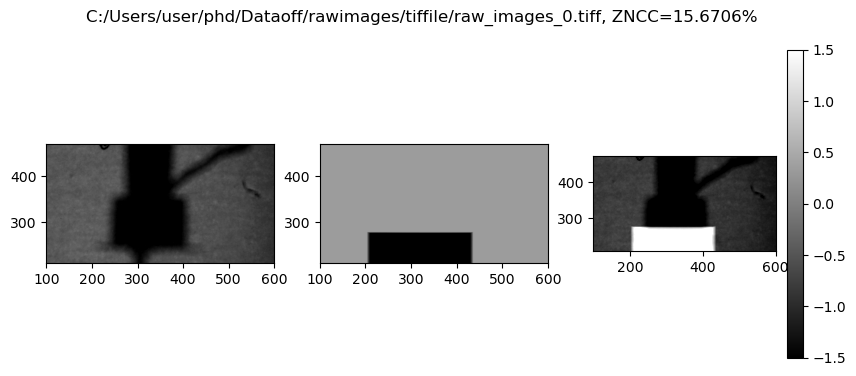

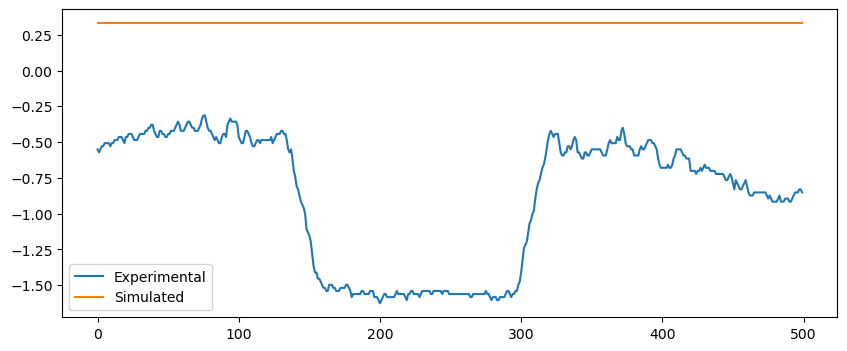

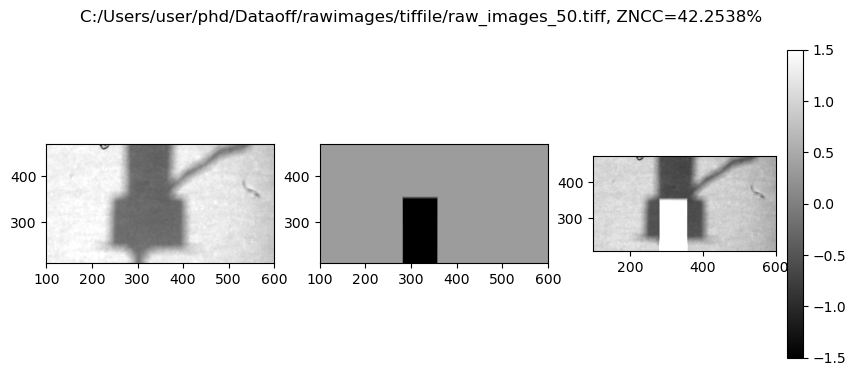

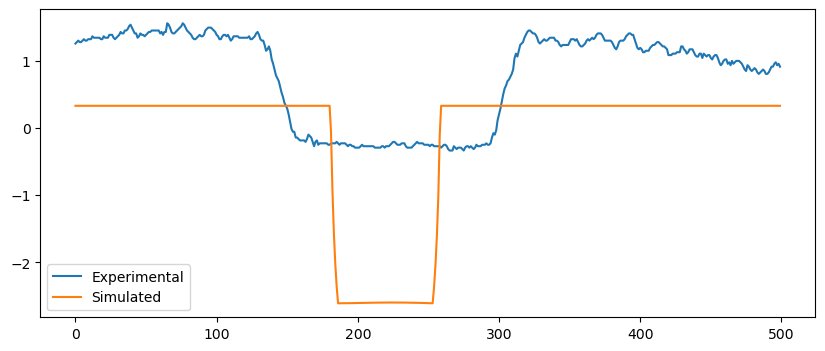

In [25]:
displayResult(6*[0.0])

In [26]:
visualise()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [27]:
help(gvxr)

Help on module gvxrPython3._gvxrPython3.temp_gvxrPython3 in gvxrPython3._gvxrPython3:

NAME
    gvxrPython3._gvxrPython3.temp_gvxrPython3

DESCRIPTION
    # This file was automatically generated by SWIG (http://www.swig.org).
    # Version 4.0.0
    #
    # Do not make changes to this file unless you know what you are doing--modify
    # the SWIG interface file instead.

CLASSES
    builtins.object
        SwigPyIterator
        Vectord
        Vectordd
        Vectorddd
        Vectorf
        Vectorff
        Vectorfff
        Vectori
        Vectors
        Vectorss
        Vectorui
    
    class SwigPyIterator(builtins.object)
     |  SwigPyIterator(*args, **kwargs)
     |  
     |  Methods defined here:
     |  
     |  __add__(self, n)
     |  
     |  __eq__(self, x)
     |      Return self==value.
     |  
     |  __iadd__(self, n)
     |  
     |  __init__(self, *args, **kwargs)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  __isub